In [54]:
import xarray as xr
import numpy as np
import xesmf
import matplotlib.pyplot as plt
import matplotlib as mpl
# Any import of metpy will activate the accessors
import glob
import pandas as pd
import scipy
import metpy
from metpy.interpolate import interpolate_to_points
import cmocean
import cartopy
import cartopy.crs as ccrs
import math
import cmaps
import cftime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from matplotlib.transforms import Affine2D
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
import scipy.sparse as sps
import warnings

# Define flooding functions

In [55]:
def ffill_one_point_northlat(arr):
    #Forward fill only the first NaN value in each row.
    mask=xr.where(np.isnan(arr),0,1)
    fmask=(mask + mask.shift(lat=1))/2
    farr = xr.where(fmask==0.5, arr.shift(lat=1),arr)
    return farr

def ffill_one_point_southlat(arr):
    #Forward fill only the first NaN value in each row.
    mask=xr.where(np.isnan(arr),0,1)
    fmask=(mask + mask.shift(lat=-1))/2
    farr = xr.where(fmask==0.5, arr.shift(lat=-1),arr)
    return farr

def ffill_one_point_depth(arr):
    #Forward fill only the first NaN value in each row.
    mask=xr.where(np.isnan(arr),0,1)
    fmask=(mask + mask.shift(depth=1))/2
    farr = xr.where(fmask==0.5, arr.shift(depth=1),arr)
    return farr

# Define Taylor function

In [56]:
class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        #ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        #ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = []

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        if corrcoef>=0.999:
          """
          Add constant centered RMS difference contours, defined by *levels*.
          """
          levels=np.arange(0.5,6,1.)
          # Add reference point and stddev contour
          t = np.linspace(0, self.tmax)
          r = np.zeros_like(t) + stddev
          self.ax.plot(t, r, 'k--', label='_')

          rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, self.tmax))
          # Compute centered RMS difference
          rms = np.sqrt(stddev**2 + rs**2 - 2*stddev*rs*np.cos(ts))

          contours = self.ax.contour(ts, rs, rms, levels,colors='grey')
          plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

# Define variables and paths

In [57]:
var='Temp'
varN='thetao'
varG='thetao'
varA='T068'
units='$\degree$C'

outdir='/data/ghervieux/NG_NMS_NN'

# Read GLORYS Temperature, extract Surface array.

In [58]:
# Read temperature
def preprocess(ds):
    return ds.sel(longitude=slice(239,241)).\
              sel(latitude=slice(33.2,34.8)).\
              sel(depth=slice(0,300))
datadir="/Projects/Air_Sea/jscott/GLORYS/Monthlies"
fileg=f'{datadir}/{varG}.mon.mean.1993-2019.CalCS.nc'
DG=xr.open_dataset(fileg).pipe(preprocess)
DG=DG.sel(time=slice('1993-01-01','2019-12-31'))
DG=DG.isel(depth=0)
DG=DG[varG]
DG=DG.load()

# Define grid input for interpolation module
DDD=DG.isel(time=1)
DDD=DDD.rename({'longitude':'lon','latitude':'lat'})

# Define landseamask and build lon2d: Xg and lat2d: Yg
landseamaskG=xr.where(np.isnan(DG.isel(time=1))==False,1,np.nan)
Xg,Yg=np.meshgrid(landseamaskG.longitude,landseamaskG.latitude)

# Read NEP Temperature, extract surface and 01/01/1993 array.

In [59]:
# Define grid input for interpolation module
# Get right LON, LAT
DD=xr.open_dataset('/scratch/jliu/NEP10k/NEP_ocean_static_nomask.nc')
DD=DD.isel(xh=slice(230,246)).isel(yh=slice(195,210))
deptho=DD['deptho']
DD=DD[['deptho','geolon','geolat']]
DD=DD.rename({'geolon':'lon','geolat':'lat'})

# Read temperature
filen=f'/scratch/jliu/NEP10k/ocean_monthly_z.199301-201912.{varN}.nc'
DN=xr.open_dataset(filen)
DN=DN.sel(time=slice('1993-01-01','2019-12-31'))
DN=DN.isel(xh=slice(230,246)).isel(yh=slice(195,210))
DN=DN.assign_coords({'longitude':DD.lon,'latitude':DD.lat})
DN=DN.isel(z_l=0)
DN=DN[varN]
DN=DN.load()

# Define landseamask
landseamaskN=xr.where(np.isnan(DN.isel(time=1))==False,1,np.nan)

# Read PnB temperature at the Surface.

In [60]:
dirin='/data/ghervieux/NG_NMS'
DS=xr.open_dataset(f'{dirin}/PnB_Temp2.nc')
obs=DS['obs'].isel(depth=0)

df=DS['time']
lonC=DS['longitude'].data
latC=DS['latitude'].data
latC=xr.DataArray(latC,dims=['npts'])
lonC=xr.DataArray(lonC,dims=['npts'])
# create grid output
lonCC=xr.DataArray(lonC,dims=['lon'])
latCC=xr.DataArray(latC,dims=['lat'])
ds_out = xr.Dataset(coords=dict(lat=latCC,lon=lonCC))

#########
## test 1: No Flooding, NN= Nearest Neighboor Interpolation 
#########

In [61]:
#########
### GLORYS
######### 

regridder_G_NN = xesmf.Regridder(DDD, ds_out, "nearest_s2d")
DGptsi = regridder_G_NN(DG)
#---
DGdpts =np.zeros((len(df),len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['time','npts'],
        coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[:,i]=DGptsi[:,i,i].values

#######
### NEP
#######

regridder_N_NN = xesmf.Regridder(DD, ds_out, "nearest_s2d")
DNptsi = regridder_N_NN(DN)
#---
DNdpts =np.zeros((len(df),len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['time','npts'],
          coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[:,i]=DNptsi[:,i,i].values



/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


In [62]:
glo=DGdpts.where(obs>0.)
nep=DNdpts.where(obs>0.)  

# PLOT Taylor Diagram

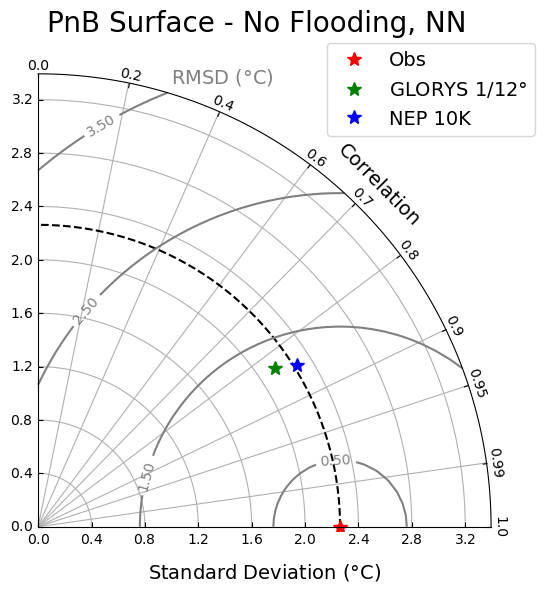

In [63]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

fig,axs  = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
# Add grid
dia.add_grid()
axs.axis('off')
# Add a figure legend
fig.legend(dia.samplePoints,
                        [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
plt.text(0.41,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)

plt.suptitle(f'PnB Surface - No Flooding, NN',fontsize=20)
outfile=f'PLOTS/PnB_TaylorDiagram_test1.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT scatter

/tmp/ipykernel_2181728/3899035533.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_2181728/3899035533.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


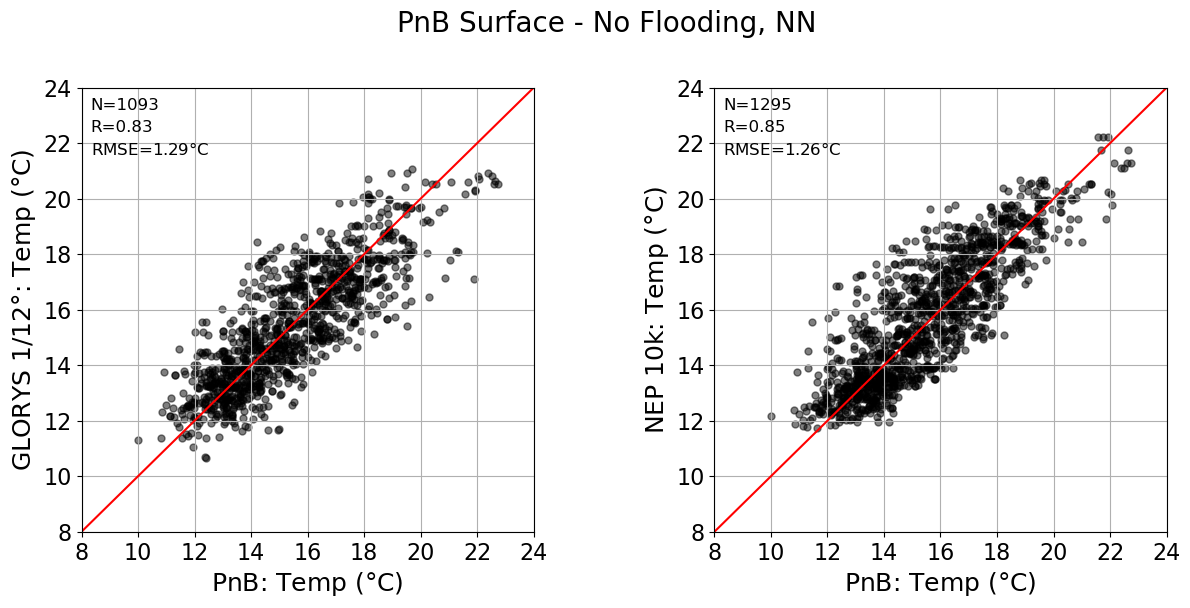

In [64]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

for i in range(len(axs)):
  axs[i].set_ylim(8,24)
  axs[i].set_xlim(8,24)
  axs[i].grid()
  axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
  axs[i].set_xlabel('PnB: Temp ($\degree$C)',fontsize=18)

axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

plt.suptitle(f'PnB Surface - No Flooding, NN',fontsize=20)
outfile=f'PLOTS/PnB_Scatter_test1.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 2: No Flooding, bilinear Interpolation 
#########

# Interpolation via xesmf module

In [65]:

### GLORYS
##### Interp H
lonCC=xr.DataArray(lonC,dims=['lon'])
latCC=xr.DataArray(latC,dims=['lat'])
ds_out = xr.Dataset(coords=dict(lat=latCC,lon=lonCC))
regridder_G_bi = xesmf.Regridder(DDD, ds_out, "bilinear")
DGptsi = regridder_G_bi(DG)
#---
DGdpts =np.zeros((len(df),len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['time','npts'],
        coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[:,i]=DGptsi[:,i,i].values

#####
### NEP
##### Interp H
lonCC=xr.DataArray(lonC,dims=['lon'])
latCC=xr.DataArray(latC,dims=['lat'])
ds_out = xr.Dataset(coords=dict(lat=latCC,lon=lonCC))
regridder_N_bi = xesmf.Regridder(DD, ds_out, "bilinear")
DNptsi = regridder_N_bi(DN)
#---
DNdpts =np.zeros((len(df),len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['time','npts'],
          coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[:,i]=DNptsi[:,i,i].values

glo=DGdpts.where(obs>0.)
nep=DNdpts.where(obs>0.)  

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT Taylor Diagram

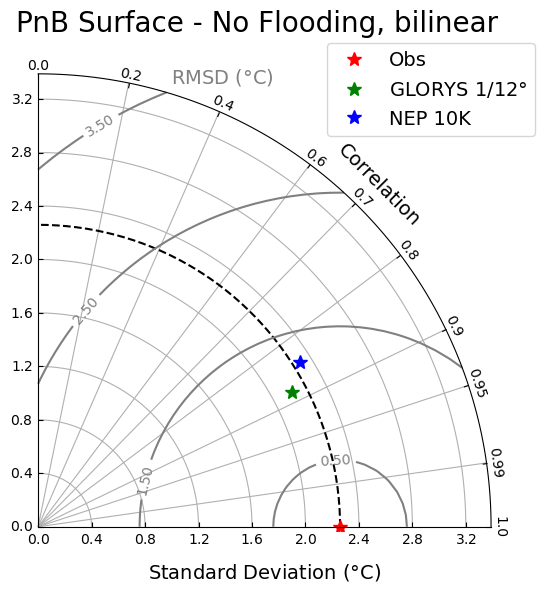

In [66]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

fig,axs  = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
# Add grid
dia.add_grid()
axs.axis('off')
# Add a figure legend
fig.legend(dia.samplePoints,
                        [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
plt.text(0.41,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)

plt.suptitle(f'PnB Surface - No Flooding, bilinear',fontsize=20)
outfile=f'PLOTS/PnB_TaylorDiagram_test2.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT scatter

/tmp/ipykernel_2181728/710061474.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_2181728/710061474.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


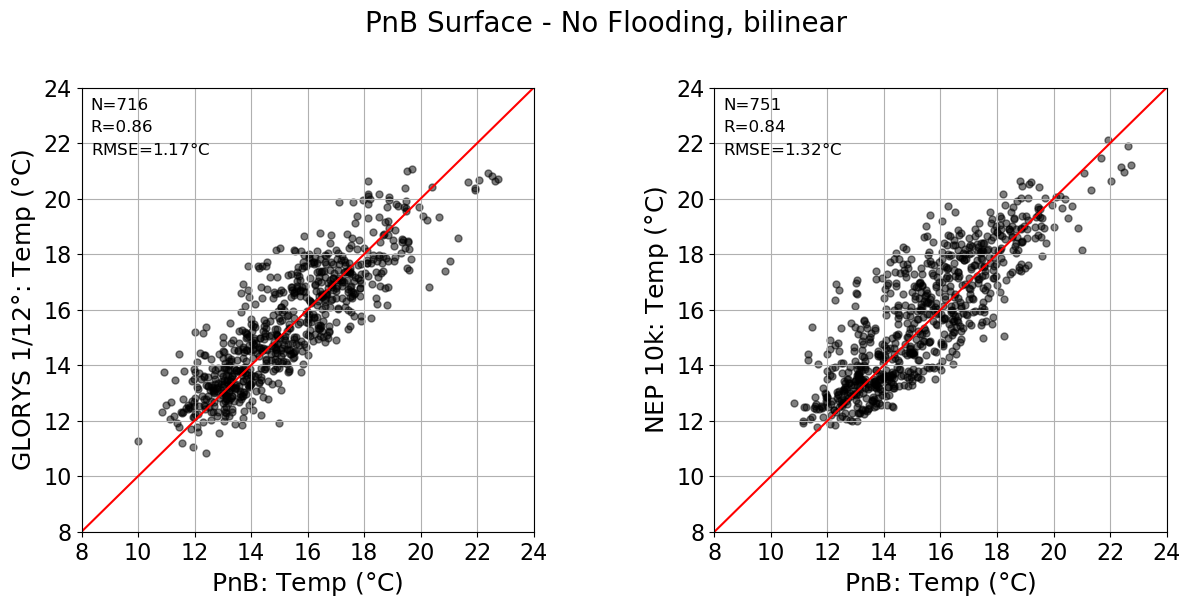

In [67]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

for i in range(len(axs)):
  axs[i].set_ylim(8,24)
  axs[i].set_xlim(8,24)
  axs[i].grid()
  axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
  axs[i].set_xlabel('PnB: Temp ($\degree$C)',fontsize=18)

axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

plt.suptitle(f'PnB Surface - No Flooding, bilinear',fontsize=20)
outfile=f'PLOTS/PnB_Scatter_test2.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 3: Southward Flooding, NN= Nearest Neighboor Interpolation 
#########

# Southward Flooding

In [68]:
# GLORYS
DGs=ffill_one_point_southlat(DG.rename({'latitude':'lat'}))
DGs=DGs.rename({'lat':'latitude'})

# NEP
DNs=ffill_one_point_southlat(DN.rename({'yh':'lat'}))
DNs=DNs.rename({'lat':'yh'})


# Interpolation via xesmf module

In [69]:
#########
### GLORYS
##### Interp H

DGptsi = regridder_G_NN(DGs)
#---
DGdpts =np.zeros((len(df),len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['time','npts'],
        coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[:,i]=DGptsi[:,i,i].values

#######
### NEP
##### Interp H

DNptsi = regridder_N_NN(DNs)
#---
DNdpts =np.zeros((len(df),len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['time','npts'],
          coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[:,i]=DNptsi[:,i,i].values

glo=DGdpts.where(obs>0.)
nep=DNdpts.where(obs>0.)  

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT Taylor Diagram

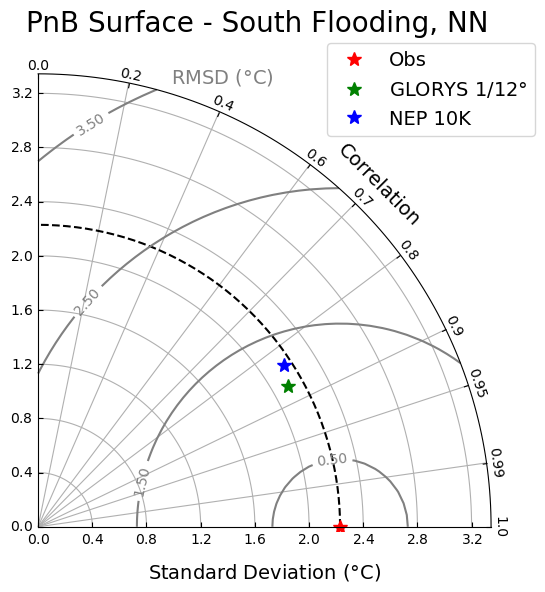

In [70]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

fig,axs  = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
# Add grid
dia.add_grid()
axs.axis('off')
# Add a figure legend
fig.legend(dia.samplePoints,
                        [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
plt.text(0.41,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)

plt.suptitle(f'PnB Surface - South Flooding, NN',fontsize=20)
outfile=f'PLOTS/PnB_TaylorDiagram_test3.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT scatter

/tmp/ipykernel_2181728/2413308141.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_2181728/2413308141.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


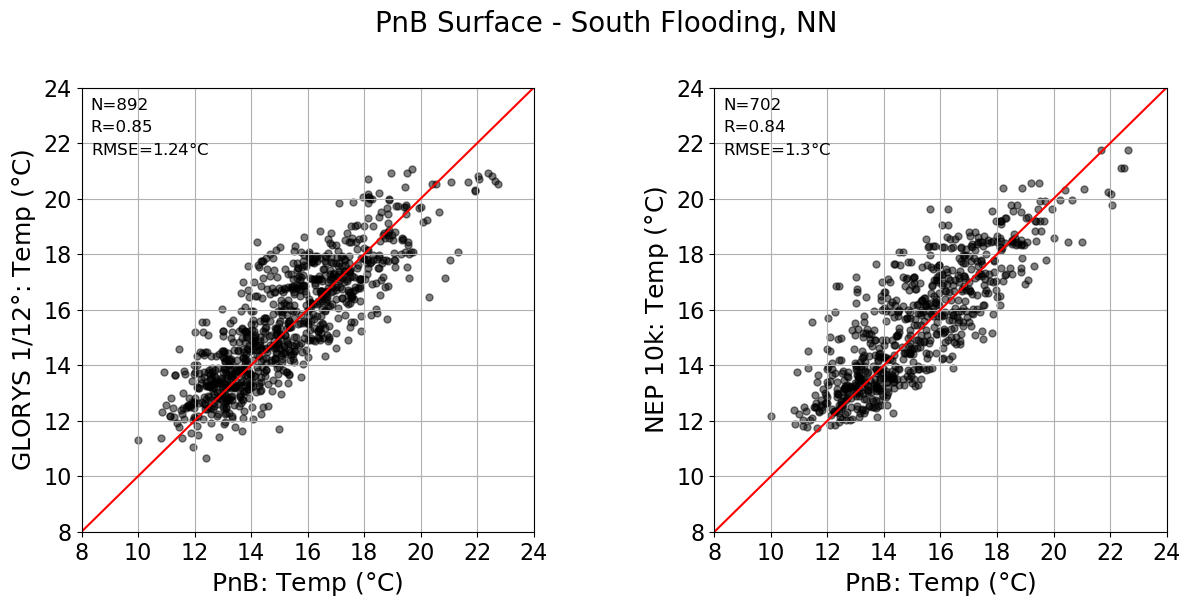

In [71]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

for i in range(len(axs)):
  axs[i].set_ylim(8,24)
  axs[i].set_xlim(8,24)
  axs[i].grid()
  axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
  axs[i].set_xlabel('PnB: Temp ($\degree$C)',fontsize=18)

axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

plt.suptitle(f'PnB Surface - South Flooding, NN',fontsize=20)
outfile=f'PLOTS/PnB_Scatter_test3.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 4: Southward Flooding, bilinear Interpolation 
#########

# Interpolation via xesmf module

In [72]:
### GLORYS
##### Interp H

DGptsi = regridder_G_bi(DGs)
#---
DGdpts =np.zeros((len(df),len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['time','npts'],
        coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[:,i]=DGptsi[:,i,i].values

#####
### NEP
##### Interp H

DNptsi = regridder_N_bi(DNs)
#---
DNdpts =np.zeros((len(df),len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['time','npts'],
          coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[:,i]=DNptsi[:,i,i].values

glo=DGdpts.where(obs>0.)
nep=DNdpts.where(obs>0.)    

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT Taylor Diagram

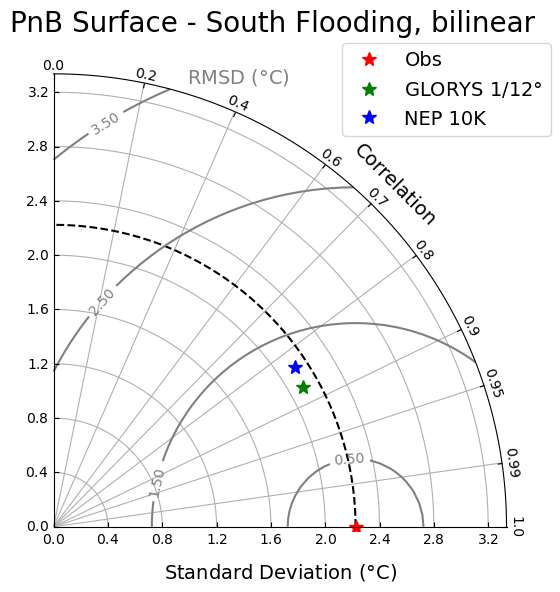

In [73]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

fig,axs  = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
# Add grid
dia.add_grid()
axs.axis('off')
# Add a figure legend
fig.legend(dia.samplePoints,
                        [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
plt.text(0.41,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)

plt.suptitle(f'PnB Surface - South Flooding, bilinear',fontsize=20)
outfile=f'PLOTS/PnB_TaylorDiagram_test4.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT scatter

/tmp/ipykernel_2181728/3260515181.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_2181728/3260515181.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


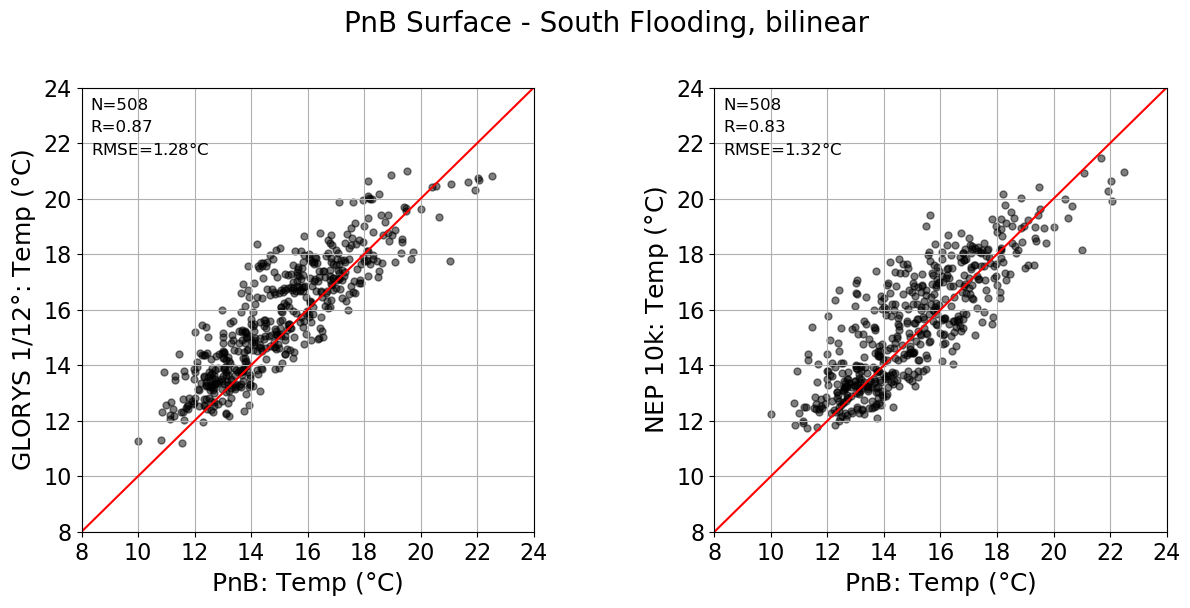

In [74]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

for i in range(len(axs)):
  axs[i].set_ylim(8,24)
  axs[i].set_xlim(8,24)
  axs[i].grid()
  axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
  axs[i].set_xlabel('PnB: Temp ($\degree$C)',fontsize=18)

axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

plt.suptitle(f'PnB Surface - South Flooding, bilinear',fontsize=20)
outfile=f'PLOTS/PnB_Scatter_test4.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 5: Northward Flooding, NN= Nearest Neighboor Interpolation 
#########

# Northward Flooding

In [75]:
# GLORYS
DGn=ffill_one_point_northlat(DG.rename({'latitude':'lat'}))
DGn=DGn.rename({'lat':'latitude'})

# NEP
DNn=ffill_one_point_northlat(DN.rename({'yh':'lat'}))
DNn=DNn.rename({'lat':'yh'})

# Interpolation via xesmf module

In [76]:
#########
### GLORYS
##### Interp H

DGptsi = regridder_G_NN(DGn)
#---
DGdpts =np.zeros((len(df),len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['time','npts'],
        coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[:,i]=DGptsi[:,i,i].values

#######
### NEP
##### Interp H

DNptsi = regridder_N_NN(DNn)
#---
DNdpts =np.zeros((len(df),len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['time','npts'],
          coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[:,i]=DNptsi[:,i,i].values

glo=DGdpts.where(obs>0.)
nep=DNdpts.where(obs>0.)    

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT Taylor Diagram

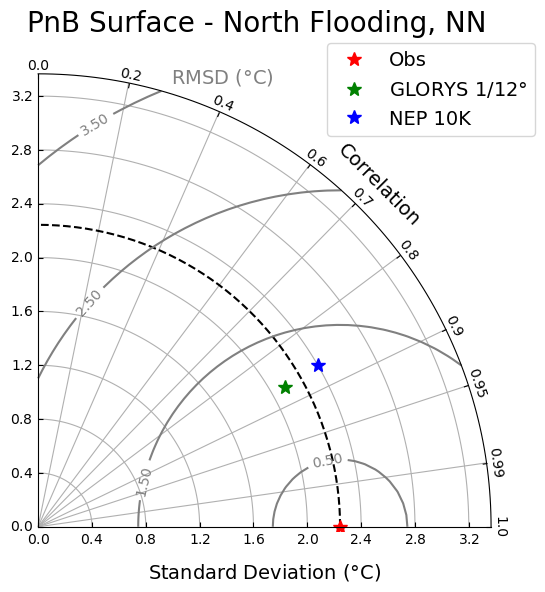

In [77]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

fig,axs  = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
# Add grid
dia.add_grid()
axs.axis('off')
# Add a figure legend
fig.legend(dia.samplePoints,
                        [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
plt.text(0.41,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)

plt.suptitle(f'PnB Surface - North Flooding, NN',fontsize=20)
outfile=f'PLOTS/PnB_TaylorDiagram_test5.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT scatter

/tmp/ipykernel_2181728/454118374.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_2181728/454118374.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


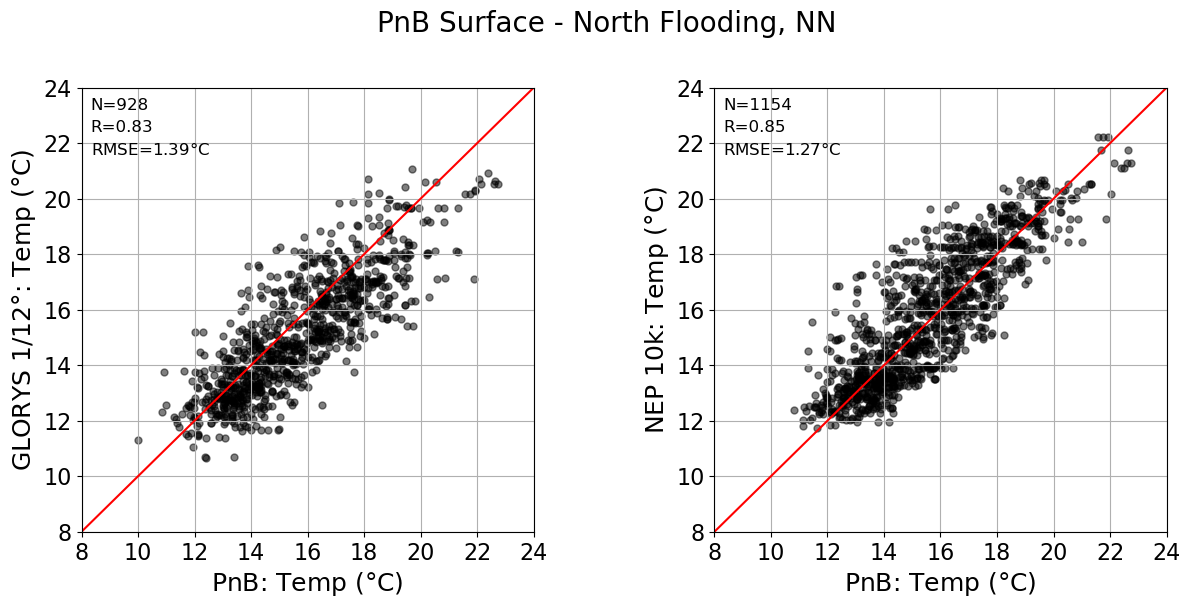

In [78]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

for i in range(len(axs)):
  axs[i].set_ylim(8,24)
  axs[i].set_xlim(8,24)
  axs[i].grid()
  axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
  axs[i].set_xlabel('PnB: Temp ($\degree$C)',fontsize=18)

axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

plt.suptitle(f'PnB Surface - North Flooding, NN',fontsize=20)
outfile=f'PLOTS/PnB_Scatter_test5.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 6: Northward Flooding, bilinear Interpolation 
#########

# Interpolation via xesmf module

In [79]:
### GLORYS
##### Interp H

DGptsi = regridder_G_bi(DGn)
#---
DGdpts =np.zeros((len(df),len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['time','npts'],
        coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[:,i]=DGptsi[:,i,i].values

#####
### NEP
##### Interp H

DNptsi = regridder_N_bi(DNn)
#---
DNdpts =np.zeros((len(df),len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['time','npts'],
          coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[:,i]=DNptsi[:,i,i].values

glo=DGdpts.where(obs>0.)
nep=DNdpts.where(obs>0.)    

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT Taylor Diagram

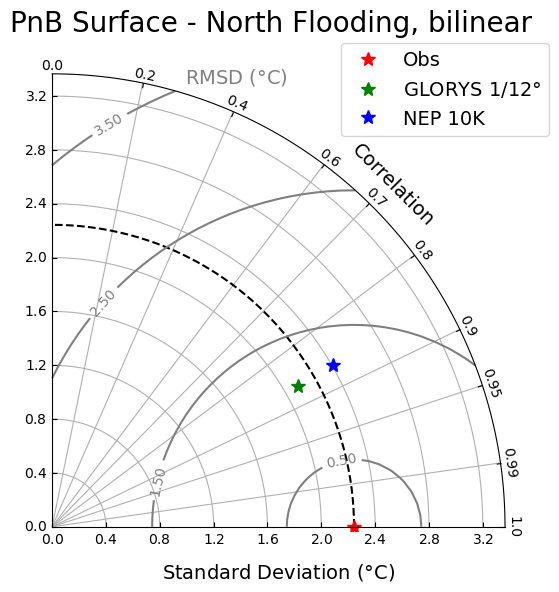

In [80]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

fig,axs  = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
# Add grid
dia.add_grid()
axs.axis('off')
# Add a figure legend
fig.legend(dia.samplePoints,
                        [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
plt.text(0.41,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)

plt.suptitle(f'PnB Surface - North Flooding, bilinear',fontsize=20)
outfile=f'PLOTS/PnB_TaylorDiagram_test6.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT scatter

/tmp/ipykernel_2181728/23617875.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_2181728/23617875.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


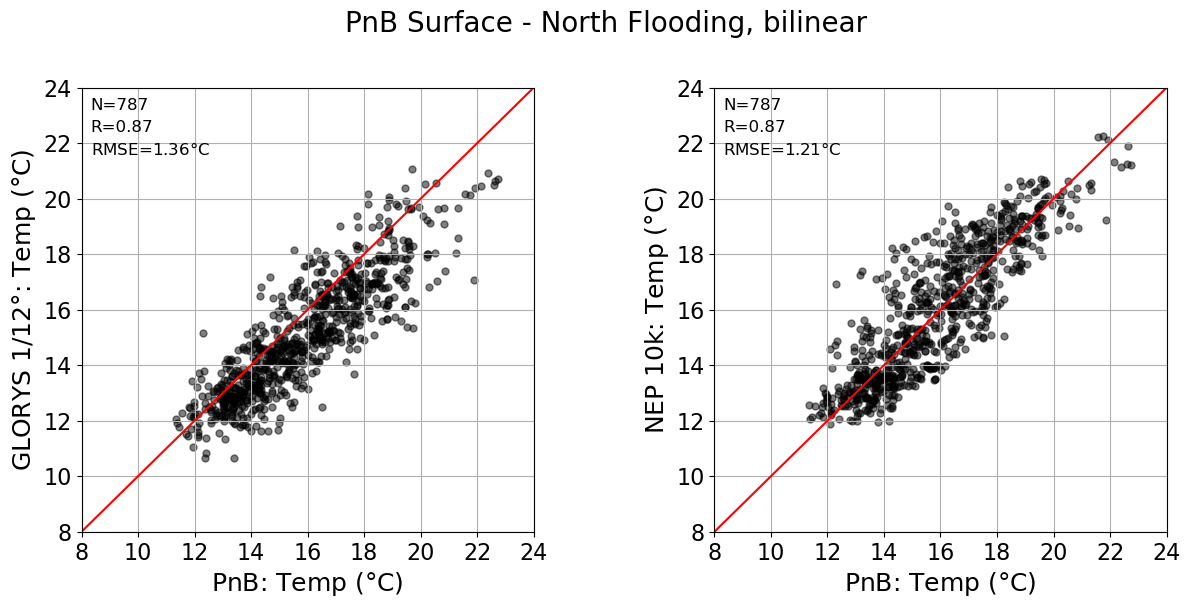

In [81]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

for i in range(len(axs)):
  axs[i].set_ylim(8,24)
  axs[i].set_xlim(8,24)
  axs[i].grid()
  axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
  axs[i].set_xlabel('PnB: Temp ($\degree$C)',fontsize=18)

axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

plt.suptitle(f'PnB Surface - North Flooding, bilinear',fontsize=20)
outfile=f'PLOTS/PnB_Scatter_test6.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 7: Coastward Flooding, NN Interpolation 
#########

# New Flooding functions lat dependant

In [82]:

def ffill_one_point_coastward_G(arr):
  mask=xr.where(np.isnan(arr),0,1)
  fmaskn=((mask + mask.shift(latitude=1))/2).where(arr.latitude>34.2) 
  fmasks=((mask + mask.shift(latitude=-1))/2).where(arr.latitude<=34.2) 
  farr = xr.where(fmaskn==0.5, arr.shift(latitude=1),arr)
  farr = xr.where(fmasks==0.5, farr.shift(latitude=-1),farr)
  return farr

def ffill_one_point_coastward_N(arr):
  mask=xr.where(np.isnan(arr),0,1)
  fmaskn=((mask + mask.shift(yh=1))/2).where(arr.latitude>34.2) 
  fmasks=((mask + mask.shift(yh=-1))/2).where(arr.latitude<=34.2) 
  farr = xr.where(fmaskn==0.5, arr.shift(yh=1),arr)
  farr = xr.where(fmasks==0.5, farr.shift(yh=-1),farr)
  return farr

In [83]:
# GLORYS
DGns=ffill_one_point_coastward_G(DG)

# NEP
DNns=ffill_one_point_coastward_N(DN)

# Interpolation via xesmf module

In [84]:
### GLORYS
##### Interp H

DGptsi = regridder_G_NN(DGns)
#---
DGdpts =np.zeros((len(df),len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['time','npts'],
        coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[:,i]=DGptsi[:,i,i].values

#####
### NEP
##### Interp H

DNptsi = regridder_N_NN(DNns)
#---
DNdpts =np.zeros((len(df),len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['time','npts'],
          coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[:,i]=DNptsi[:,i,i].values

glo=DGdpts.where(obs>0.)
nep=DNdpts.where(obs>0.)    

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT Taylor Diagram

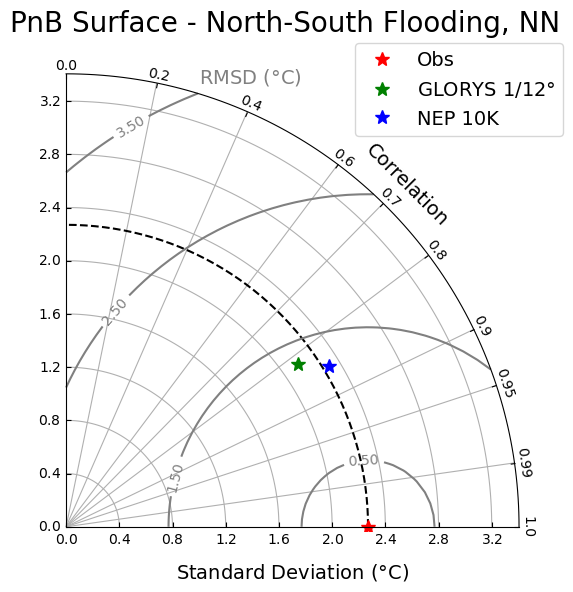

In [85]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

fig,axs  = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
# Add grid
dia.add_grid()
axs.axis('off')
# Add a figure legend
fig.legend(dia.samplePoints,
                        [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
plt.text(0.41,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)

plt.suptitle(f'PnB Surface - North-South Flooding, NN',fontsize=20)
outfile=f'PLOTS/PnB_TaylorDiagram_test7.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT scatter

/tmp/ipykernel_2181728/2442358753.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_2181728/2442358753.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


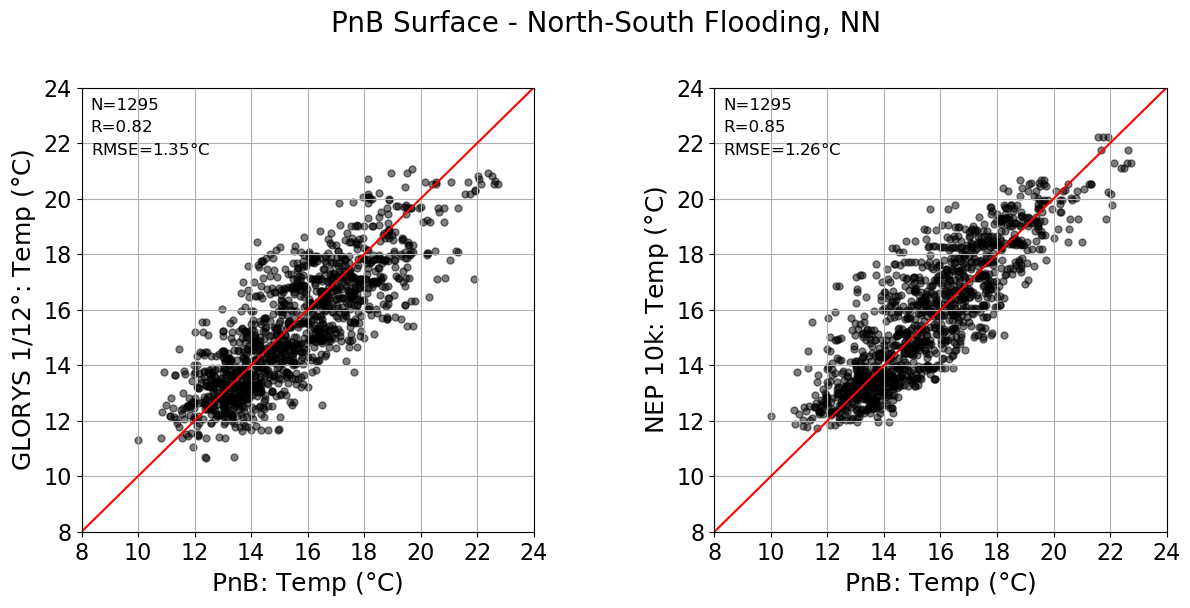

In [86]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

for i in range(len(axs)):
  axs[i].set_ylim(8,24)
  axs[i].set_xlim(8,24)
  axs[i].grid()
  axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
  axs[i].set_xlabel('PnB: Temp ($\degree$C)',fontsize=18)

axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

plt.suptitle(f'PnB Surface - North-South Flooding, NN',fontsize=20)
outfile=f'PLOTS/PnB_Scatter_test7.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 8: Coastward Flooding, bilinear Interpolation 
#########

# Interpolation via xesmf module

In [87]:
### GLORYS
##### Interp H

DGptsi = regridder_G_bi(DGns)
#---
DGdpts =np.zeros((len(df),len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['time','npts'],
        coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[:,i]=DGptsi[:,i,i].values

#####
### NEP
##### Interp H

DNptsi = regridder_N_bi(DNns)
#---
DNdpts =np.zeros((len(df),len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['time','npts'],
          coords={'time':df,'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[:,i]=DNptsi[:,i,i].values

glo=DGdpts.where(obs>0.)
nep=DNdpts.where(obs>0.)    

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT Taylor Diagram

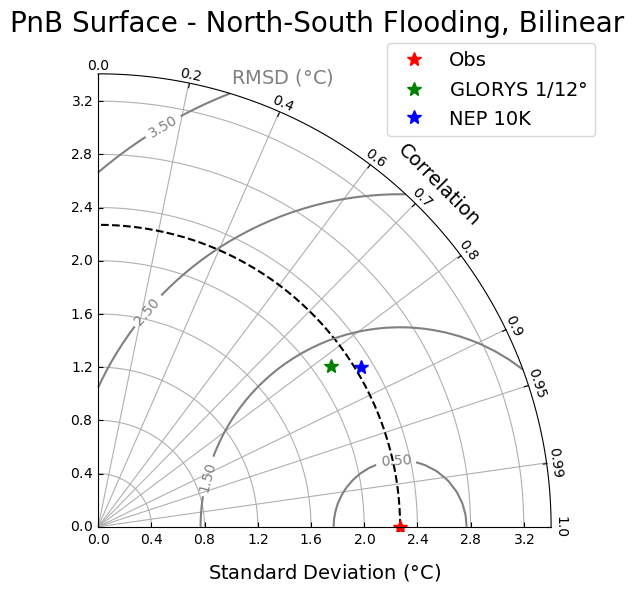

In [88]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

fig,axs  = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
# Add grid
dia.add_grid()
axs.axis('off')
# Add a figure legend
fig.legend(dia.samplePoints,
                        [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
plt.text(0.41,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)

plt.suptitle(f'PnB Surface - North-South Flooding, Bilinear',fontsize=20)
outfile=f'PLOTS/PnB_TaylorDiagram_test8.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT scatter

/tmp/ipykernel_2181728/3313510927.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_2181728/3313510927.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


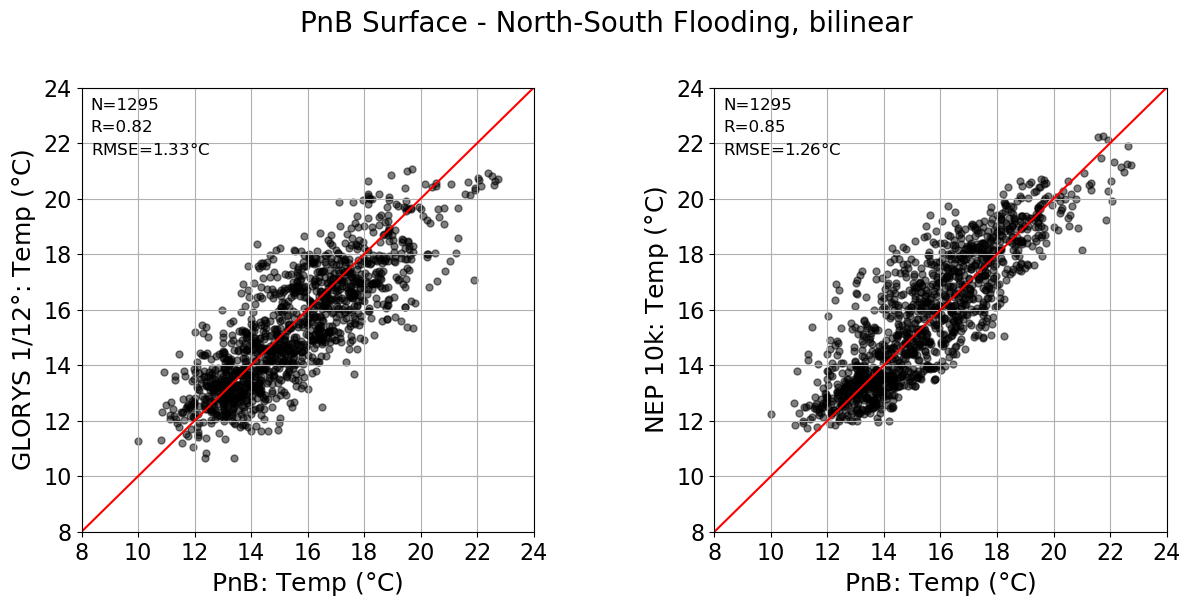

In [89]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

for i in range(len(axs)):
  axs[i].set_ylim(8,24)
  axs[i].set_xlim(8,24)
  axs[i].grid()
  axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
  axs[i].set_xlabel('PnB: Temp ($\degree$C)',fontsize=18)

axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

plt.suptitle(f'PnB Surface - North-South Flooding, bilinear',fontsize=20)
outfile=f'PLOTS/PnB_Scatter_test8.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')